## To analyse the training result

### Set parameters

In [1]:
RUN_ID = 20 # set this to prevent overlapped saving of model and data
VARIANCE_THRESHOLD = True
ROOT_DIR = "/scratch1/sachinsa/monai_data_1"

In [2]:
import os
import matplotlib.pyplot as plt

import pdb
import numpy as np
import pickle
from dataset import BrainMRIDataset
from logger import Logger

logger = Logger(log_level='DEBUG')

[INFO] Logging level is: DEBUG


In [3]:
load_dir = os.path.join(ROOT_DIR, f"run_{RUN_ID}")
fig_save_dir = os.path.join("..", "figs", f"run_{RUN_ID}")
os.makedirs(fig_save_dir, exist_ok=True)

In [4]:
with open(os.path.join(load_dir, 'training_info.pkl'), 'rb') as f:
    training_info = pickle.load(f)
    epoch_loss_values = training_info['epoch_loss_values']
    metric_values = training_info['metric_values']

with open(os.path.join(load_dir, 'params.pkl'), 'rb') as f:
    params = pickle.load(f)
    DO_MASK = params['DO_MASK']
    QR_REGRESSION = params['QR_REGRESSION']

logger.info("PARAMETERS\n-----------------")
logger.info(f"RUN_ID: {RUN_ID}")
logger.info(f"QR_REGRESSION: {QR_REGRESSION}")
logger.info(f"DO_MASK: {DO_MASK}")
logger.info(f"ROOT_DIR: {ROOT_DIR}")
print("")

[INFO] PARAMETERS
-----------------
[INFO] RUN_ID: 20
[INFO] QR_REGRESSION: True
[INFO] DO_MASK: True
[INFO] ROOT_DIR: /scratch1/sachinsa/monai_data_1



In [5]:
max_epochs = len(epoch_loss_values)
val_interval = len(epoch_loss_values)//len(metric_values)

In [6]:
len(epoch_loss_values)

4600

In [7]:
nan_ratio = np.sum(np.isnan(epoch_loss_values))/len(epoch_loss_values)
print(f"{100*nan_ratio:.1f}% of values are nan!!!")

0.0% of values are nan!!!


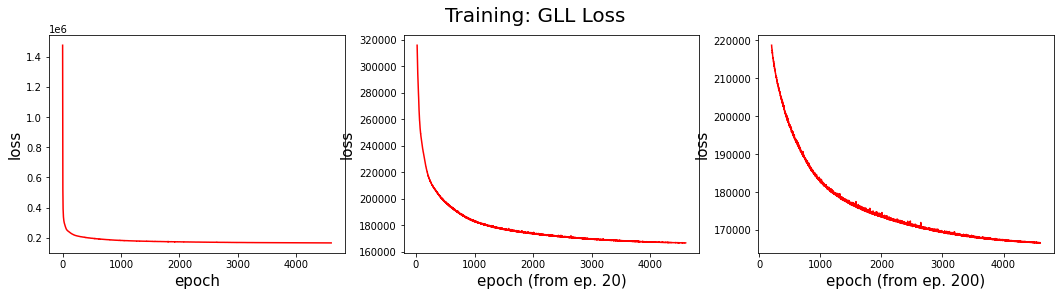

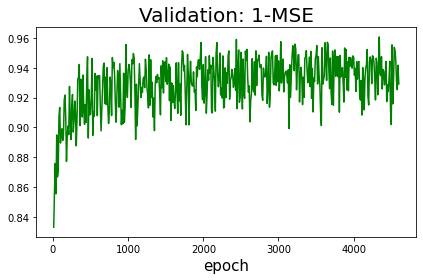

In [8]:
MULTI_TRAINING_FIGURE = True

if not MULTI_TRAINING_FIGURE:
    plt.figure("train", (6, 4))
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.ylabel("loss - log")
    plt.yscale('log')
    plt.plot(x, y, color="red")
    plt.title("Training: Gaussian Log Likelihood Loss", fontsize=25)
    plt.savefig(os.path.join(fig_save_dir, "train_plot.png"), facecolor='white')
    plt.show()
else:
    plt.figure("train", (18, 4))
    plt.subplot(1, 3, 1)
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch", fontsize=15)
    plt.ylabel("loss", fontsize=15)
    # plt.ylabel("loss - log", fontsize=15)
    # plt.yscale('log')
    plt.plot(x, y, color="red")
    plt.suptitle("Training: GLL Loss", fontsize=20)

    k = 2
    for zoom in [20, 200]:
        if len(x) > zoom:
            plt.subplot(1, 3, k)
            x = [i + 1 for i in range(len(epoch_loss_values))]
            y = epoch_loss_values
            plt.ylabel("loss", fontsize=15)
            plt.xlabel(f"epoch (from ep. {zoom})", fontsize=15)
            
            plt.plot(x[zoom:], y[zoom:], color="red")
        k += 1
    plt.savefig(os.path.join(fig_save_dir, "train_plot.png"), facecolor='white')
    plt.show()

plt.figure("val", (6, 4))
plt.title("Validation: 1-MSE", fontsize=20)
x_val = [val_interval * (i + 1) for i in range(len(metric_values))]
y_val = metric_values
plt.xlabel("epoch", fontsize=15)
plt.tight_layout()
plt.plot(x_val, y_val, color="green")
plt.savefig(os.path.join(fig_save_dir, "val_plot.png"), facecolor='white')
plt.show()

## Inference on the model

In [9]:
import torch
from monai.networks.nets import UNet
from monai.transforms import (
    LoadImage,
    NormalizeIntensity,
    Orientation,
    CenterSpatialCrop,
    Resize,
    Spacing,
    EnsureType,
    EnsureChannelFirst,
)
from monai.transforms import (
    Compose,
)
from torch.utils.data import Dataset

In [10]:
device = torch.device("cuda:0")
out_channels = 12 if QR_REGRESSION else 8
model = UNet(
    spatial_dims=3, # 3D
    in_channels=4,
    out_channels=out_channels,
    channels=(4, 8, 16),
    strides=(2, 2),
    num_res_units=2
).to(device)

VAL_AMP = True

# define inference method
def inference(input):
    def _compute(input):
        output = model(input)
        return output

    if VAL_AMP:
        with torch.amp.autocast('cuda'):
            return _compute(input)
    else:
        return _compute(input)

In [15]:
# PIXEL_DOWNSAMPLE = [2, 2, 2]
# crop_size = [224, 224, 144]
# resize_size = [crop_size[i]//PIXEL_DOWNSAMPLE[i] for i in range(len(crop_size))]
resize_size = [64,64,64]

val_transform = Compose(
    [
        LoadImage(),
        EnsureChannelFirst(),
        EnsureType(),
        Orientation(axcodes="RAS"),
        # Spacing(
        #     pixdim=(1.0, 1.0, 1.0),
        #     mode=("bilinear", "nearest"),
        # ),
        # CenterSpatialCrop(roi_size=crop_size), # added this because model was not handling 155dims
        # Resize(spatial_size=resize_size, mode='nearest'),
        NormalizeIntensity(nonzero=True, channel_wise=True),
    ]
)

In [16]:
all_dataset = BrainMRIDataset(
    root_dir=ROOT_DIR,
    transform = val_transform
)

In [27]:
checkpoint = torch.load(os.path.join(load_dir, 'latest_checkpoint.pth'), weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
channels = ["FLAIR", "T1w", "T1gd", "T2w"]

with torch.no_grad():
    this_input = all_dataset[0]
    input_image = this_input["image"].unsqueeze(0).to(device)
    if DO_MASK:
        input_mask = [True, False, True, False]
        channels = [f"{ch} (X)" if mask else ch for ch, mask in zip(channels, input_mask)]
        input_image_copy = input_image.clone()
        input_image_copy[:, input_mask, ...] = 0
    this_output = inference(input_image_copy)

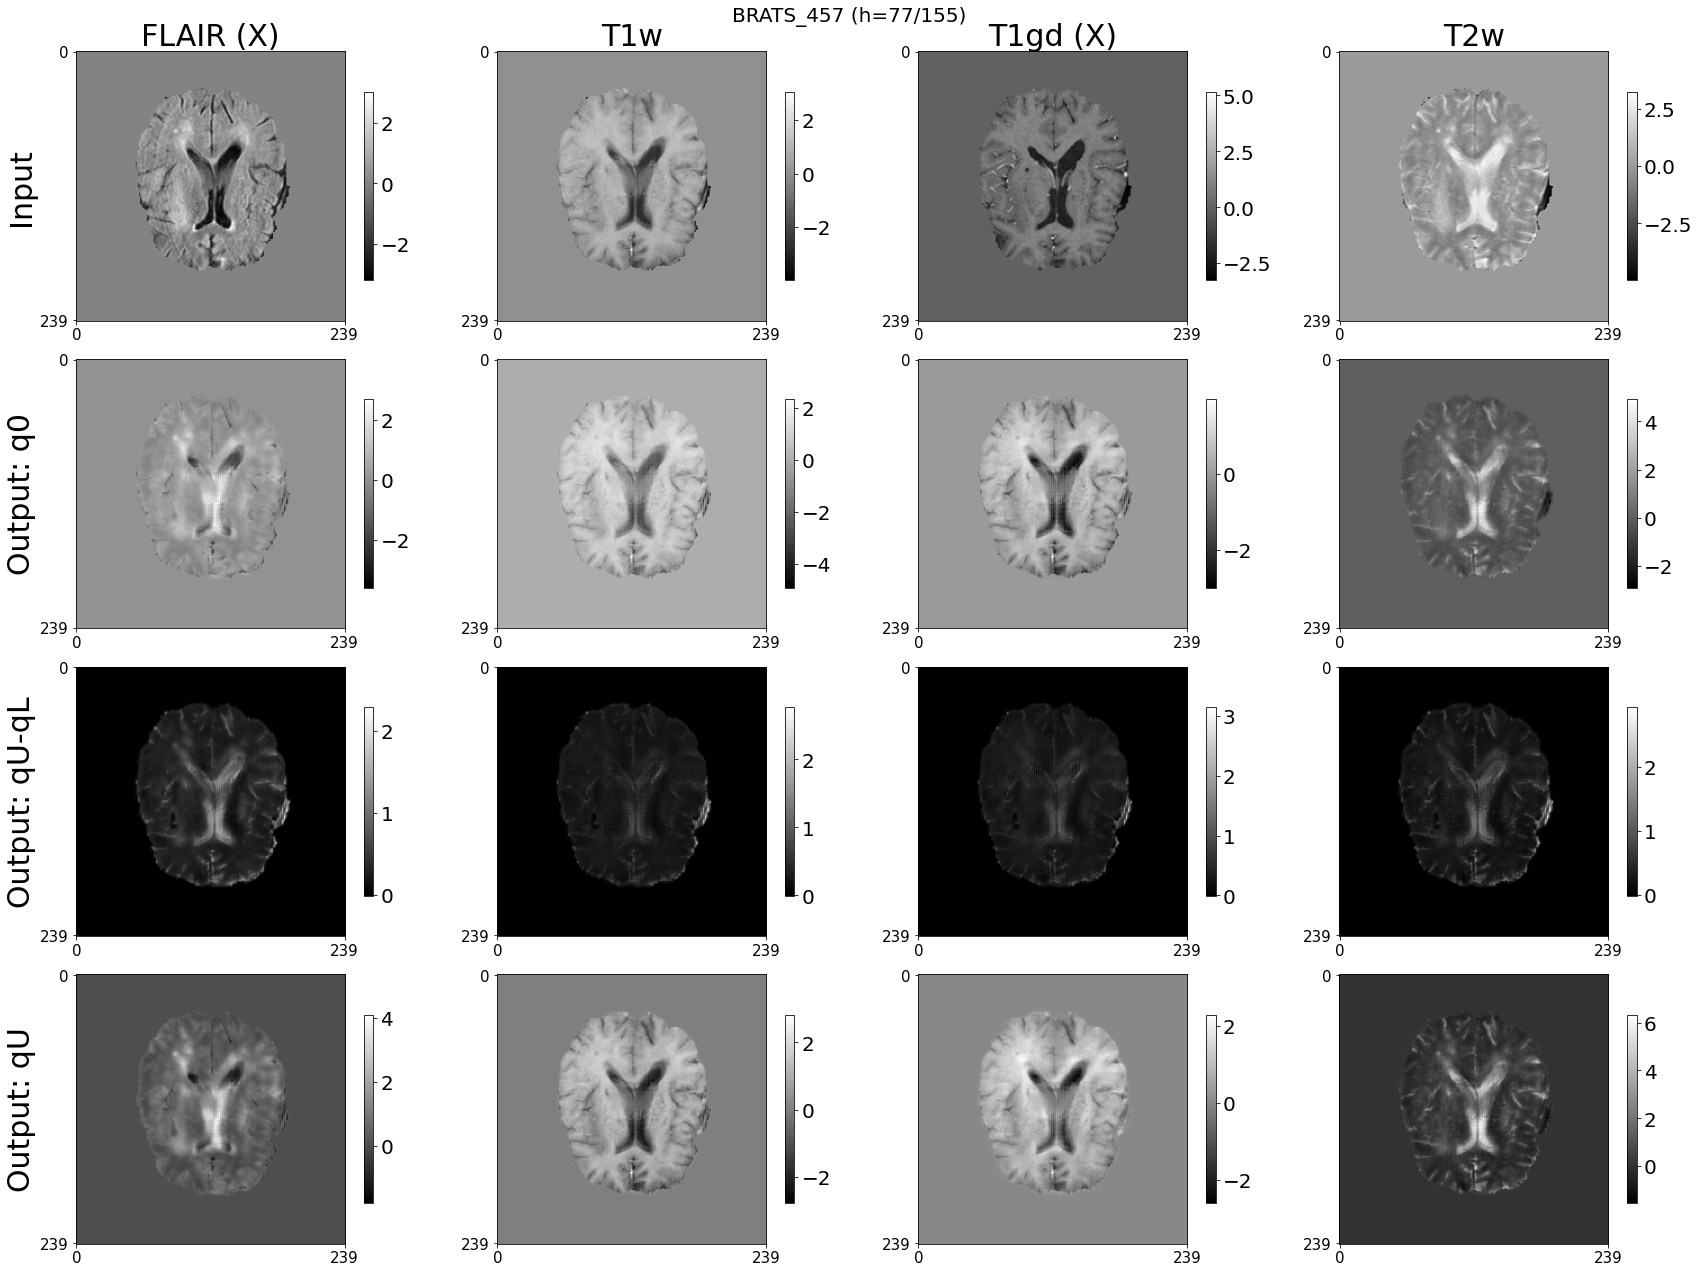

In [31]:
_, _, im_length, im_width, im_height = input_image.shape
h_index = im_height//2

def plot_brain(index, label):
    start_index = None
    title = ""
    this_output_sub = this_output[0, :, :, :, h_index]

    if label == "input":
        start_index = 0
        title = "Input"
        brain_slice = input_image[0, index, :, :, h_index]
    elif label == "mean":
        start_index = 4
        title = "Output: " + r"$\mu$"
        brain_slice = this_output_sub[index]
    elif label == "var":
        start_index = 8
        title = "Output: " + r"$\sigma$" + ""
        brain_slice = this_output_sub[index+4]
        brain_slice = torch.exp(brain_slice)
        if VARIANCE_THRESHOLD:
            var_threshold = torch.quantile(brain_slice.float(), 0.95).item()
            brain_slice[brain_slice >= var_threshold] = var_threshold
    elif label == "q0":
        start_index = 4
        title = "Output: " + "q0"
        brain_slice = this_output_sub[index]
    elif label == "q1":
        start_index = 8
        title = "Output: " + r"qU-qL" + ""
        brain_slice = 0.5*(this_output_sub[index+8] - this_output_sub[index+4])
    elif label == "q2":
        start_index = 12
        title = "Output: " + r"qU" + ""
        brain_slice = this_output_sub[index+8]
    num_rows = 4 if QR_REGRESSION else 3
    plt.subplot(num_rows, 4, start_index + index + 1)
    if label == "input":
        plt.title(channels[i], fontsize=30)
    brain_slice = brain_slice.detach().cpu().T
    plt.imshow(brain_slice, cmap="gray")
    plt.xlabel('')
    if i == 0:
        plt.ylabel(title, fontsize=30)
    plt.xticks([0, im_width - 1], [0, im_width - 1], fontsize=15)
    plt.yticks([0, im_length - 1], [0, im_length - 1], fontsize=15)
    cbar = plt.colorbar(shrink=0.7)
    cbar.ax.tick_params(labelsize=20)

plt.figure("image", (24, 18))
for i in range(4):
    plot_brain(i, "input")
if QR_REGRESSION:
    for i in range(4):
        plot_brain(i, "q0")
    for i in range(4):
        plot_brain(i, "q1")
    for i in range(4):
        plot_brain(i, "q2")
else:
    for i in range(4):
        plot_brain(i, "mean")
    for i in range(4):
        plot_brain(i, "var")

plt.suptitle(f"{this_input['id']} (h={h_index}/{im_height})", fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, "model_inference.png"), facecolor='white')
plt.show()